# Librerias

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, EfficientNetB4, EfficientNetB5, MobileNetV2, InceptionV3, Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, legacy as legacy_optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import wandb
from wandb.integration.keras import WandbCallback
from tqdm import tqdm
from tqdm.keras import TqdmCallback

# PyTorch and torchvision (for comparative or dual-framework examples, adjust as necessary)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Abordar el Desbalance

**Código para Contar Imágenes por Clase y Conjunto**

In [2]:
import os

def count_images_in_splits(data_splits_dir):
    splits = ['train', 'val', 'test']
    split_counts = {}
    
    for split in splits:
        split_dir = os.path.join(data_splits_dir, split)
        class_counts = {}
        total_count = 0
        
        if os.path.exists(split_dir):
            classes = sorted(os.listdir(split_dir))
            for cls in classes:
                cls_dir = os.path.join(split_dir, cls)
                if os.path.isdir(cls_dir):
                    count = len(os.listdir(cls_dir))
                    class_counts[cls] = count
                    total_count += count
            split_counts[split] = {'total': total_count, 'classes': class_counts}
        else:
            print(f"El directorio {split_dir} no existe.")
    return split_counts

# Directorio principal donde se encuentran los splits
data_split_dir = 'data_split'

# Obtener los conteos
split_counts = count_images_in_splits(data_split_dir)

**Código para Mostrar Conteos**

In [3]:
def print_split_counts(split_counts):
    for split, data in split_counts.items():
        print(f"\nConjunto: {split}")
        print(f"Total de imágenes: {data['total']}")
        print("Imágenes por clase:")
        for cls, count in data['classes'].items():
            print(f"  Clase {cls}: {count} imágenes")

print_split_counts(split_counts)


Conjunto: train
Total de imágenes: 7378
Imágenes por clase:
  Clase ASC-H: 592 imágenes
  Clase ASC-US: 387 imágenes
  Clase HSIL: 1089 imágenes
  Clase LSIL: 870 imágenes
  Clase Negative: 4338 imágenes
  Clase SCC: 102 imágenes

Conjunto: val
Total de imágenes: 1847
Imágenes por clase:
  Clase ASC-H: 148 imágenes
  Clase ASC-US: 97 imágenes
  Clase HSIL: 273 imágenes
  Clase LSIL: 218 imágenes
  Clase Negative: 1085 imágenes
  Clase SCC: 26 imágenes

Conjunto: test
Total de imágenes: 2309
Imágenes por clase:
  Clase ASC-H: 185 imágenes
  Clase ASC-US: 122 imágenes
  Clase HSIL: 341 imágenes
  Clase LSIL: 272 imágenes
  Clase Negative: 1356 imágenes
  Clase SCC: 33 imágenes


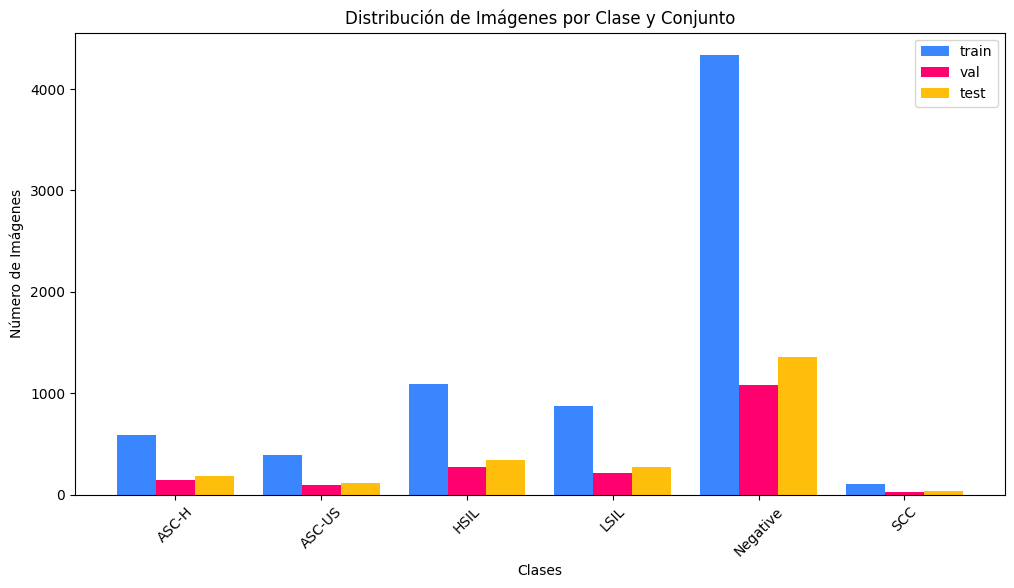

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution_per_split(split_counts):
    # Aseguramos que todas las clases estén presentes en todos los splits
    classes = sorted(set().union(*(split['classes'].keys() for split in split_counts.values())))
    splits = list(split_counts.keys())
    class_counts_per_split = {cls: [] for cls in classes}
    
    # Recolectamos los conteos para cada clase en cada split
    for split in splits:
        for cls in classes:
            count = split_counts[split]['classes'].get(cls, 0)  # Si una clase no está presente, se coloca un 0
            class_counts_per_split[cls].append(count)
    
    x = np.arange(len(classes))
    total_width = 0.8
    width = total_width / len(splits)
    
    colors = ['#3A86FF', '#FF006E', '#FFBE0B']  # Colores para los diferentes conjuntos (train, val, test)
    
    plt.figure(figsize=(12, 6))
    
    for i, split in enumerate(splits):
        counts = [class_counts_per_split[cls][i] for cls in classes]
        plt.bar(x + i * width, counts, width=width, label=split, color=colors[i])  # Cambiar color por cada conjunto
    
    plt.xlabel('Clases')
    plt.ylabel('Número de Imágenes')
    plt.title('Distribución de Imágenes por Clase y Conjunto')
    plt.xticks(x + width, classes, rotation=45)
    plt.legend()
    plt.show()

# Ejemplo de estructura 'split_counts'
split_counts = {
    'train': {
        'classes': {
            'ASC-H': 592,
            'ASC-US': 387,
            'HSIL': 1089,
            'LSIL': 870,
            'Negative': 4338,
            'SCC': 102
        }
    },
    'val': {
        'classes': {
            'ASC-H': 148,
            'ASC-US': 97,
            'HSIL': 273,
            'LSIL': 218,
            'Negative': 1085,
            'SCC': 26
        }
    },
    'test': {
        'classes': {
            'ASC-H': 185,
            'ASC-US': 114,
            'HSIL': 341,
            'LSIL': 272,
            'Negative': 1356,
            'SCC': 33
        }
    }
}

# Llamada a la función para graficar
plot_class_distribution_per_split(split_counts)

**Data Aumentation**

In [5]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Función para mejorar nitidez
def enhance_sharpness(image):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    sharp_image = cv2.filter2D(image, -1, kernel)
    return sharp_image

# Función para aplicar CLAHE
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

def augment_class_images(class_name, current_count, target_count, class_dir):
    datagen = ImageDataGenerator(
        rotation_range=10,  # Rotación limitada para no distorsionar la imagen
        width_shift_range=0.05,  # Shift más limitado
        height_shift_range=0.05,  # Shift más limitado
        shear_range=0.1,  # Cizallamiento menor
        horizontal_flip=True,
        fill_mode='nearest'
    )

    images = os.listdir(class_dir)
    num_existing_images = len(images)
    images_needed = target_count - current_count
    i = 0

    print(f"Generando {images_needed} imágenes para la clase {class_name}")

    while i < images_needed:
        img_name = images[i % num_existing_images]
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path)
        x = img_to_array(img)

        # Aplicar solo mejoras de nitidez y CLAHE para mejorar la imagen sin perder calidad
        img_array = np.array(x, dtype=np.uint8)
        sharp_img = enhance_sharpness(img_array)
        final_img = apply_clahe(sharp_img)

        # Preparar la imagen para la augmentación
        x_aug = final_img.reshape((1,) + final_img.shape)

        save_prefix = 'aug_' + img_name.split('.')[0]
        aug_iter = datagen.flow(
            x_aug,
            batch_size=1,
            save_to_dir=class_dir,
            save_prefix=save_prefix,
            save_format='png'
        )
        next(aug_iter)
        i += 1

# Directorio del conjunto de entrenamiento
train_dir = 'data_split/train'

# Definir la cantidad objetivo de imágenes por clase
target_count = 2000

# Datos de las clases
class_counts = {
    'ASC-H': 592,
    'ASC-US': 387,
    'HSIL': 1089,
    'LSIL': 870,
    'Negative': 4338,  # No necesitamos aumentar esta clase
    'SCC': 102
}

# Aplicar aumento de datos a cada clase minoritaria
for class_name, count in class_counts.items():
    if count < target_count and class_name != 'Negative':
        class_dir = os.path.join(train_dir, class_name)
        augment_class_images(class_name, count, target_count, class_dir)

Generando 1408 imágenes para la clase ASC-H


KeyboardInterrupt: 

**Comparación antes y después del Balanceo**

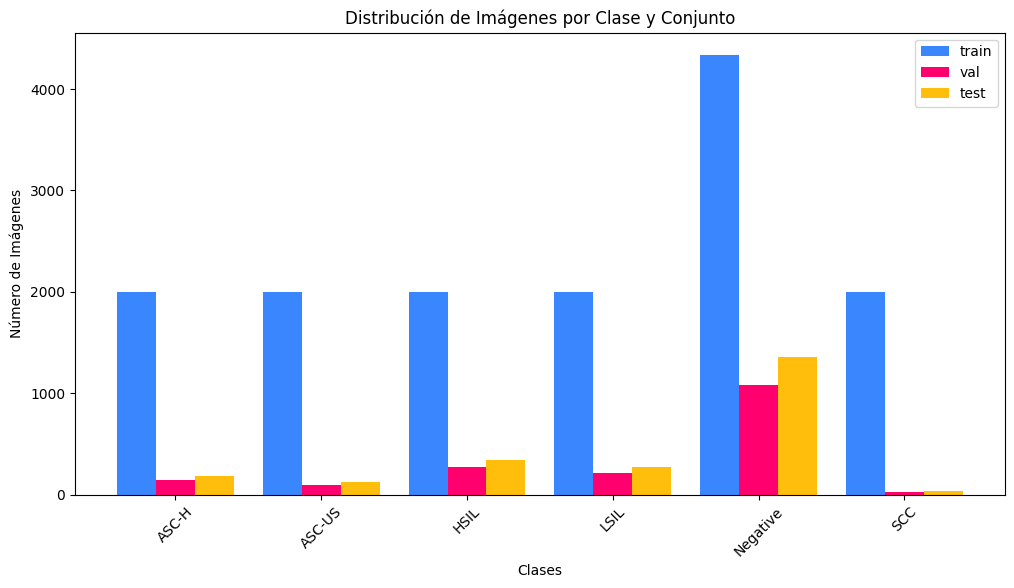

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Función para contar las imágenes en cada clase por conjunto
def count_images_in_split(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len([f for f in os.listdir(class_dir) if f.endswith('.png') or f.endswith('.jpg')])
    return class_counts

# Directorios de los conjuntos (cambia los directorios según tu estructura de carpetas)
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

# Contamos las imágenes en cada clase para cada conjunto
split_counts = {
    'train': {'classes': count_images_in_split(train_dir)},
    'val': {'classes': count_images_in_split(val_dir)},
    'test': {'classes': count_images_in_split(test_dir)}
}

# Función para graficar la distribución de imágenes por clase en cada conjunto
def plot_class_distribution_per_split(split_counts):
    # Aseguramos que todas las clases estén presentes en todos los splits
    classes = sorted(set().union(*(split['classes'].keys() for split in split_counts.values())))
    splits = list(split_counts.keys())
    class_counts_per_split = {cls: [] for cls in classes}
    
    # Recolectamos los conteos para cada clase en cada split
    for split in splits:
        for cls in classes:
            count = split_counts[split]['classes'].get(cls, 0)  # Si una clase no está presente, se coloca un 0
            class_counts_per_split[cls].append(count)
    
    x = np.arange(len(classes))
    total_width = 0.8
    width = total_width / len(splits)
    
    colors = ['#3A86FF', '#FF006E', '#FFBE0B']  # Colores para los diferentes conjuntos (train, val, test)
    
    plt.figure(figsize=(12, 6))
    
    for i, split in enumerate(splits):
        counts = [class_counts_per_split[cls][i] for cls in classes]
        plt.bar(x + i * width, counts, width=width, label=split, color=colors[i])  # Cambiar color por cada conjunto
    
    plt.xlabel('Clases')
    plt.ylabel('Número de Imágenes')
    plt.title('Distribución de Imágenes por Clase y Conjunto')
    plt.xticks(x + width, classes, rotation=45)
    plt.legend()
    plt.show()

# Llamada a la función para graficar
plot_class_distribution_per_split(split_counts)

# Modelo ViT

**Preparación de los Datos**

In [111]:
# Directorios de los conjuntos de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

# Tamaño de las imágenes y batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Generador para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Generador para el conjunto de validación
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Generador para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Importante para evaluación
)

# Obtener las etiquetas de clase
classes = train_generator.classes

# Calcular los pesos de clase
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

# Crear el diccionario de pesos de clase
class_weights = {i: weight for i, weight in enumerate(class_weights_values)}
print("Pesos de clase:", class_weights)

Found 7378 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.
Pesos de clase: {0: 2.0771396396396398, 1: 3.177433247200689, 2: 1.1291704928068564, 3: 1.4134099616858238, 4: 0.2834639618871984, 5: 12.055555555555555}


**Importar y Definir el Modelo ViT**

In [112]:
from keras_cv.models import VisionTransformerClassifier  # Importación correcta

# Definir el modelo ViT utilizando Keras-CV
model_vit = ViTClassifier.from_preset(
    "vit_base_resnet50",  # Puedes elegir el preset que prefieras
    num_classes=train_generator.num_classes,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

ImportError: cannot import name 'VisionTransformerClassifier' from 'keras_cv.models' (/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras_cv/models/__init__.py)

# Modelo ResNet50

**Preparación de los Datos**

In [10]:
# Iniciar sesión en WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='ResNet50_crossentropy')

# Directorios
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

# Parámetros
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size=BATCH_SIZE, class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=BATCH_SIZE, class_mode='categorical',
                                                classes=list(train_generator.class_indices.keys()))

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                  batch_size=BATCH_SIZE, class_mode='categorical',
                                                  shuffle=False, classes=list(train_generator.class_indices.keys()))

# Pesos de clase automáticos
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes),
                                     y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

Found 7378 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


**Cargar, Compilar y Entrenar el Modelo**

In [11]:
# Cargar modelo base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True
for layer in base_model.layers[:30]:
    layer.trainable = False

# Crear el modelo
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
x = layers.BatchNormalization()(x)  # Nueva capa de Batch Normalization
x = layers.Dropout(0.4)(x)  # Reducir Dropout
outputs = layers.Dense(len(class_weights), activation='softmax')(x)
model = keras.Model(inputs, outputs)

# Compilar el modelo con categorical_crossentropy
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Learning rate inicial más alto para explorar
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'best_weights.h5'), save_weights_only=True,
                    monitor='val_loss', mode='min', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),  # Más agresivo
    WandbCallback(save_model=False),
    TqdmCallback(verbose=1)
]

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=0
)

  0%|          | 0/5 [00:00<?, ?epoch/s]


Epoch 1: val_loss improved from inf to 19859.26172, saving model to checkpoints/best_weights.h5


 20%|██        | 1/5 [11:27<45:50, 687.71s/epoch, loss=2.58, accuracy=0.229, val_loss=1.99e+4, val_accuracy=0.0801, lr=0.0005]

KeyboardInterrupt: 

**Evaluación y Guardado de Resultados**

In [7]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

57/57 [==============================] - 50s 881ms/step - loss: 181.1545 - accuracy: 0.1667
Precisión en el conjunto de prueba: 0.1667


In [13]:
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()



Error: You must call wandb.init() before wandb.log()

**Visualización de Resultados**

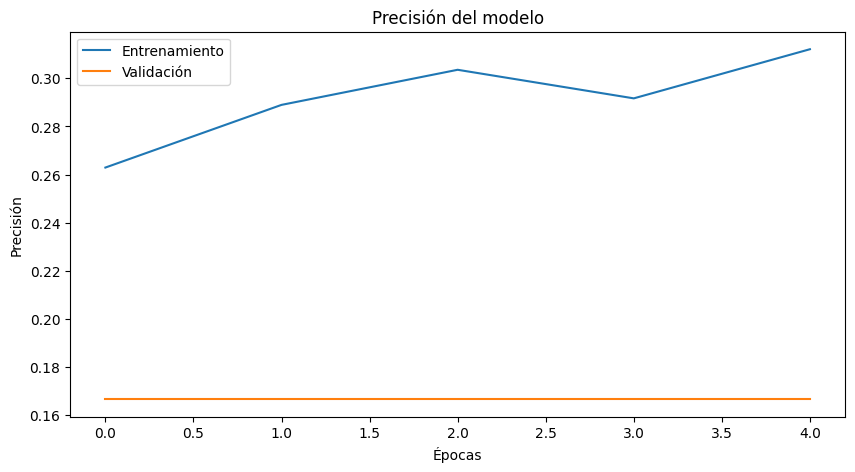

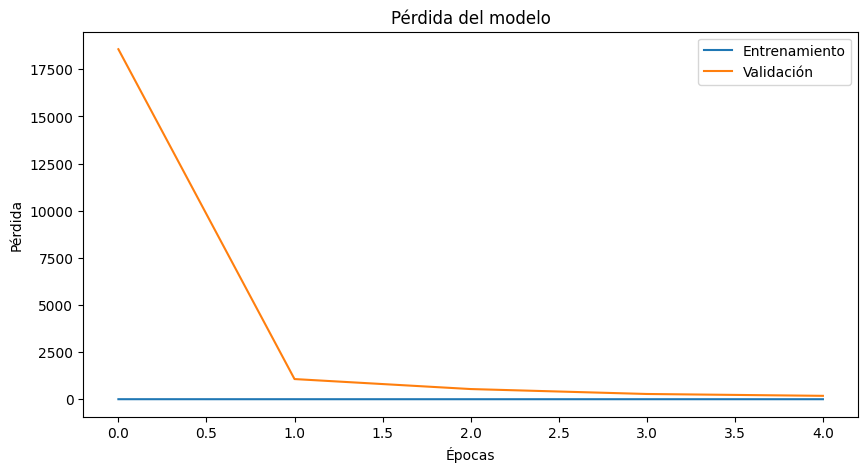

In [8]:
# Metricas de Entrenamiento 

# Gráfica de precisión
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

**Matriz de Confusión**

57/57 [==============================] - 49s 843ms/step


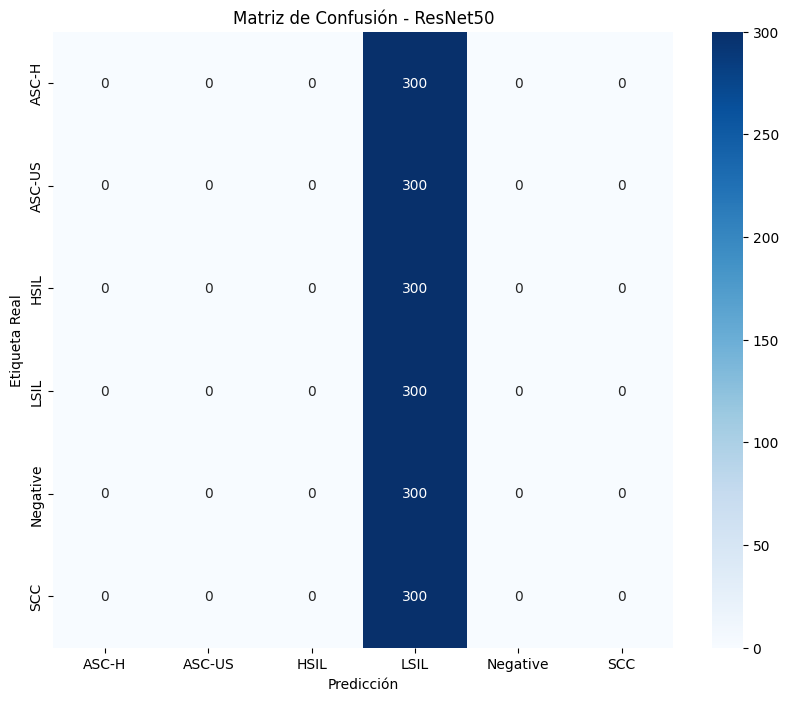

In [9]:
# Matriz de Confusión 
from sklearn.metrics import confusion_matrix

# Obtener predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - ResNet50')
plt.show()

# Modelo EfficientNetB0

**Preparación de los datos**

In [2]:
# Inicializar Weights & Biases 
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='EfficientNetB0-dataBalanceada')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.15,
    # brightness_range=[0.7, 1.3],
    # horizontal_flip=True

    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


**Importar y Definir el Modelo**

In [3]:
# Cargar y configurar el modelo EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


# inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# x = base_model(inputs, training=True)
# x = BatchNormalization()(x)  # Añadir Batch Normalization
# x = GlobalAveragePooling2D()(x)
# x = layers.Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x) 
# outputs = layers.Dense(train_generator.num_classes, activation='softmax')(x)
# model = models.Model(inputs, outputs)


# # Crea el modelo con regularización L2
# inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# x = base_model(inputs, training=True)
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Regularización L2
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(train_generator.num_classes, activation='softmax')(x)
# model = models.Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


**Entrenar el Modelo**

In [4]:
# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

Epoch 1/20
254/254 [==============================] - ETA: 0s - loss: 1.2472 - accuracy: 0.5712
Epoch 1: val_loss improved from inf to 1.04216, saving model to best_model.h5
254/254 [==============================] - 223s 855ms/step - loss: 1.2472 - accuracy: 0.5712 - val_loss: 1.0422 - val_accuracy: 0.6448 - lr: 1.0000e-04
Epoch 2/20


/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


254/254 [==============================] - ETA: 0s - loss: 1.1077 - accuracy: 0.6123
Epoch 2: val_loss improved from 1.04216 to 0.97042, saving model to best_model.h5
254/254 [==============================] - 211s 830ms/step - loss: 1.1077 - accuracy: 0.6123 - val_loss: 0.9704 - val_accuracy: 0.6594 - lr: 1.0000e-04
Epoch 3/20
254/254 [==============================] - ETA: 0s - loss: 1.0437 - accuracy: 0.6325
Epoch 3: val_loss improved from 0.97042 to 0.94354, saving model to best_model.h5
254/254 [==============================] - 215s 846ms/step - loss: 1.0437 - accuracy: 0.6325 - val_loss: 0.9435 - val_accuracy: 0.6670 - lr: 1.0000e-04
Epoch 4/20
254/254 [==============================] - ETA: 0s - loss: 0.9861 - accuracy: 0.6468
Epoch 4: val_loss improved from 0.94354 to 0.90613, saving model to best_model.h5
254/254 [==============================] - 210s 825ms/step - loss: 0.9861 - accuracy: 0.6468 - val_loss: 0.9061 - val_accuracy: 0.6784 - lr: 1.0000e-04
Epoch 5/20
254/254 [=

**Evaluar el Modelo**

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

73/73 [==============================] - 26s 351ms/step - loss: 2.1219 - accuracy: 0.5197
Precisión en el conjunto de prueba: 0.5197


accuracy,▁▂▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▂▃▄▄▄▅▅▅▇▇▇▇▇█▇▇▇█
val_loss,█▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▂▁▁▁
accuracy,0.79751
best_epoch,19
best_val_loss,0.65419


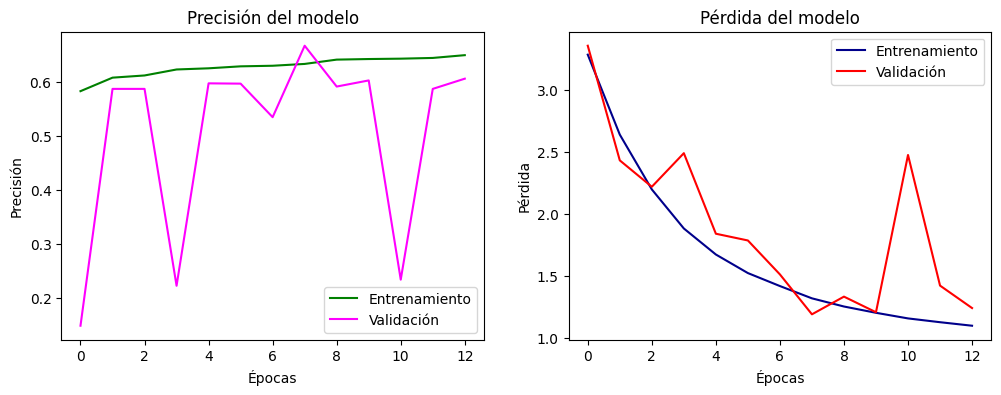

In [ ]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

73/73 [==============================] - 27s 353ms/step
              precision    recall  f1-score   support

       ASC-H       0.12      0.07      0.09       185
      ASC-US       0.15      0.07      0.10       122
        HSIL       0.20      0.13      0.16       341
        LSIL       0.14      0.10      0.12       272
    Negative       0.63      0.80      0.71      1356
         SCC       0.00      0.00      0.00        33

    accuracy                           0.51      2309
   macro avg       0.21      0.20      0.20      2309
weighted avg       0.43      0.51      0.46      2309



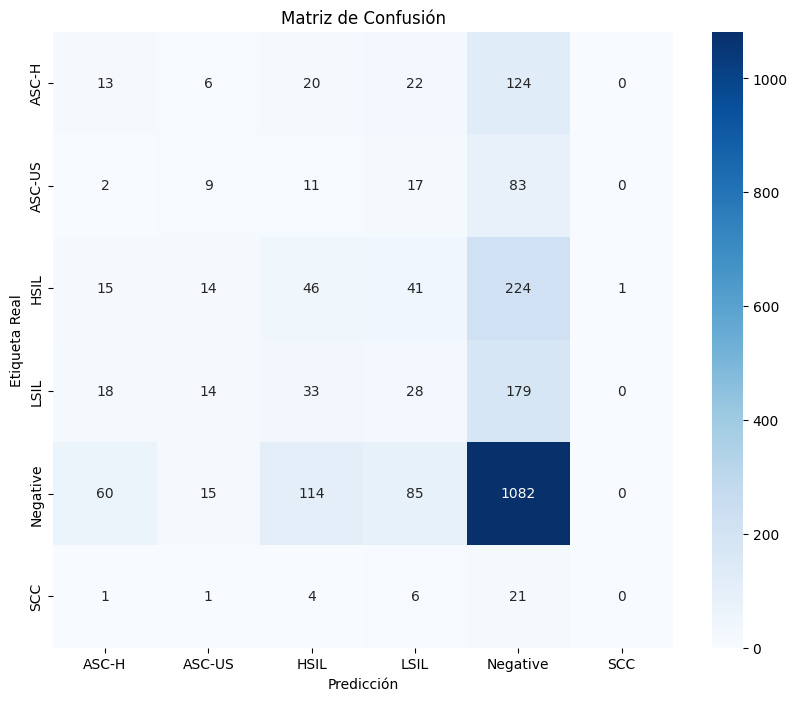

In [ ]:
# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

# Modelo EfficientNetB4

**Preparación de los datos**

In [2]:
# Inicializar Weights & Biases 
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='EfficientNetB4-balanceado')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.15,
    # brightness_range=[0.7, 1.3],
    # horizontal_flip=True

    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


**Importar y Definir el Modelo**

In [3]:
# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


**Entrenar el Modelo**

In [4]:
# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

Epoch 1/20
254/254 [==============================] - ETA: 0s - loss: 1.0508 - accuracy: 0.6141
Epoch 1: val_loss improved from inf to 0.82181, saving model to best_model.h5


/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


254/254 [==============================] - 779s 3s/step - loss: 1.0508 - accuracy: 0.6141 - val_loss: 0.8218 - val_accuracy: 0.6973 - lr: 1.0000e-04
Epoch 2/20
254/254 [==============================] - ETA: 0s - loss: 0.7587 - accuracy: 0.7189
Epoch 2: val_loss improved from 0.82181 to 0.68545, saving model to best_model.h5
254/254 [==============================] - 779s 3s/step - loss: 0.7587 - accuracy: 0.7189 - val_loss: 0.6854 - val_accuracy: 0.7488 - lr: 1.0000e-04
Epoch 3/20
254/254 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.7610
Epoch 3: val_loss improved from 0.68545 to 0.63454, saving model to best_model.h5
254/254 [==============================] - 855s 3s/step - loss: 0.6543 - accuracy: 0.7610 - val_loss: 0.6345 - val_accuracy: 0.7656 - lr: 1.0000e-04
Epoch 4/20
254/254 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.7909
Epoch 4: val_loss improved from 0.63454 to 0.63084, saving model to best_model.h5
254/254 [==========

**Evaluar el Modelo**

In [5]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

73/73 [==============================] - 75s 1s/step - loss: 2.1716 - accuracy: 0.4833
Precisión en el conjunto de prueba: 0.4833


accuracy,▁▃▄▄▅▆▆▆▇▇▇█████
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁▁
lr,███████████▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▆▆▇▆▆▇▇▇▇███
val_loss,█▄▂▂▂▁▁▁▃▁▃▂▂▃▂▃
accuracy,0.96875
best_epoch,5
best_val_loss,0.58558


NameError: name 'history' is not defined

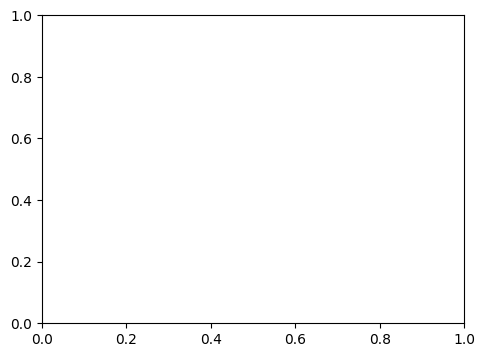

In [7]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

In [8]:
# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

73/73 [==============================] - 72s 956ms/step


NameError: name 'classification_report' is not defined

# Modelo EfficientNetB5

**Preparación de los datos**

In [2]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='EfficientNetB5')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 7378 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


**Importar y Definir el Modelo**

In [4]:
# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

115263384/115263384 [==============================] - 7s 0us/step


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


**Entrenar el Modelo**

In [5]:
# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

Epoch 1/20
231/231 [==============================] - ETA: 0s - loss: 0.9646 - accuracy: 0.6640
Epoch 1: val_loss improved from inf to 0.73877, saving model to best_model.h5


/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


231/231 [==============================] - 1133s 5s/step - loss: 0.9646 - accuracy: 0.6640 - val_loss: 0.7388 - val_accuracy: 0.7277 - lr: 1.0000e-04
Epoch 2/20
231/231 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.7433
Epoch 2: val_loss improved from 0.73877 to 0.65595, saving model to best_model.h5
231/231 [==============================] - 1111s 5s/step - loss: 0.7158 - accuracy: 0.7433 - val_loss: 0.6560 - val_accuracy: 0.7612 - lr: 1.0000e-04
Epoch 3/20
231/231 [==============================] - ETA: 0s - loss: 0.6100 - accuracy: 0.7768
Epoch 3: val_loss improved from 0.65595 to 0.62855, saving model to best_model.h5
231/231 [==============================] - 1165s 5s/step - loss: 0.6100 - accuracy: 0.7768 - val_loss: 0.6286 - val_accuracy: 0.7802 - lr: 1.0000e-04
Epoch 4/20
231/231 [==============================] - ETA: 0s - loss: 0.5296 - accuracy: 0.8098
Epoch 4: val_loss improved from 0.62855 to 0.57016, saving model to best_model.h5
231/231 [=======

**Evaluar el Modelo**

In [6]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

73/73 [==============================] - 118s 2s/step - loss: 2.3593 - accuracy: 0.4968
Precisión en el conjunto de prueba: 0.4968


accuracy,▁▃▄▄▅▅▆▆▇▇▇█████
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▆▅▅▄▃▃▃▂▂▂▁▁▁▁▁
lr,███████████▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▆▅▆▆▆▆▇▇█████
val_loss,█▅▄▂▄▁▂▂▄▃▅▂▃▃▃▄
accuracy,0.97316
best_epoch,5
best_val_loss,0.54908


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


NameError: name 'history' is not defined

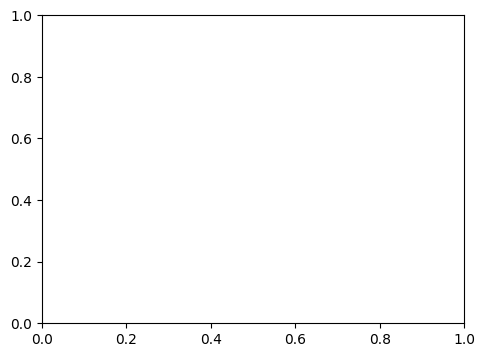

In [8]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

In [9]:
# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device: '/var/folders/9x/tdz37svs2n33397zbw458q3w0000gn/T/__autograph_generated_fileeo28fua0.py'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device: '/var/folders/9x/tdz37svs2n33397zbw458q3w0000gn/T/__autograph_generated_fileeo28fua0.py'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device: '/var/folders/9x/tdz37svs2n33397zbw458q3w0000gn/T/__autograph_generated_fileeo28fua0.py'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
73/73 [==============================] - 113s 1s/step


NameError: name 'classification_report' is not defined

# Modelo MobileNetV2

**Preparación de los datos**

In [ ]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='MobileNetV2')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


**Importar y Definir el Modelo**

In [148]:
# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_mobilenet.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

**Entrenar el Modelo**

In [142]:
# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

Epoch 1/20
231/231 [==============================] - ETA: 0s - loss: 1.0151 - accuracy: 0.6441
Epoch 1: val_loss improved from inf to 0.85304, saving model to best_model_mobilenet.h5


/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


231/231 [==============================] - 112s 470ms/step - loss: 1.0151 - accuracy: 0.6441 - val_loss: 0.8530 - val_accuracy: 0.6914 - lr: 1.0000e-04
Epoch 2/20
231/231 [==============================] - ETA: 0s - loss: 0.8602 - accuracy: 0.6930
Epoch 2: val_loss improved from 0.85304 to 0.82667, saving model to best_model_mobilenet.h5
231/231 [==============================] - 104s 451ms/step - loss: 0.8602 - accuracy: 0.6930 - val_loss: 0.8267 - val_accuracy: 0.7049 - lr: 1.0000e-04
Epoch 3/20
231/231 [==============================] - ETA: 0s - loss: 0.8014 - accuracy: 0.7151
Epoch 3: val_loss improved from 0.82667 to 0.75485, saving model to best_model_mobilenet.h5
231/231 [==============================] - 106s 460ms/step - loss: 0.8014 - accuracy: 0.7151 - val_loss: 0.7548 - val_accuracy: 0.7244 - lr: 1.0000e-04
Epoch 4/20
231/231 [==============================] - ETA: 0s - loss: 0.7705 - accuracy: 0.7236
Epoch 4: val_loss improved from 0.75485 to 0.73557, saving model to best

**Evaluar el Modelo**

In [143]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

73/73 [==============================] - 13s 176ms/step - loss: 2.2383 - accuracy: 0.5396
Precisión en el conjunto de prueba: 0.5396


accuracy,▁▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▁▁▁
lr,████████████████▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▅▆▅▆▇▇▅▇▆▆▇██████
val_loss,█▇▄▃▃▃▃▂▁▂▁▂▃▂▂▂▁▁▄▃
accuracy,0.86121
best_epoch,10
best_val_loss,0.67747


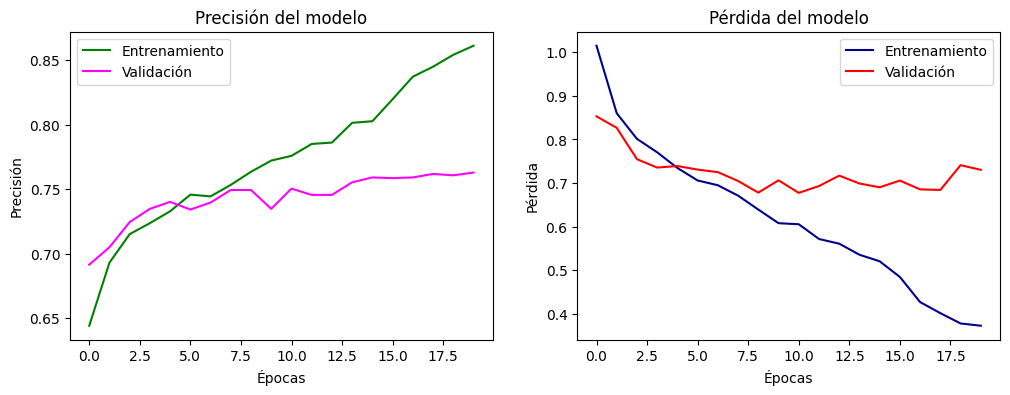

In [144]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

73/73 [==============================] - 14s 175ms/step
              precision    recall  f1-score   support

       ASC-H       0.12      0.09      0.11       185
      ASC-US       0.15      0.09      0.11       122
        HSIL       0.24      0.13      0.17       341
        LSIL       0.16      0.12      0.14       272
    Negative       0.67      0.84      0.74      1356
         SCC       0.10      0.03      0.05        33

    accuracy                           0.54      2309
   macro avg       0.24      0.22      0.22      2309
weighted avg       0.47      0.54      0.49      2309



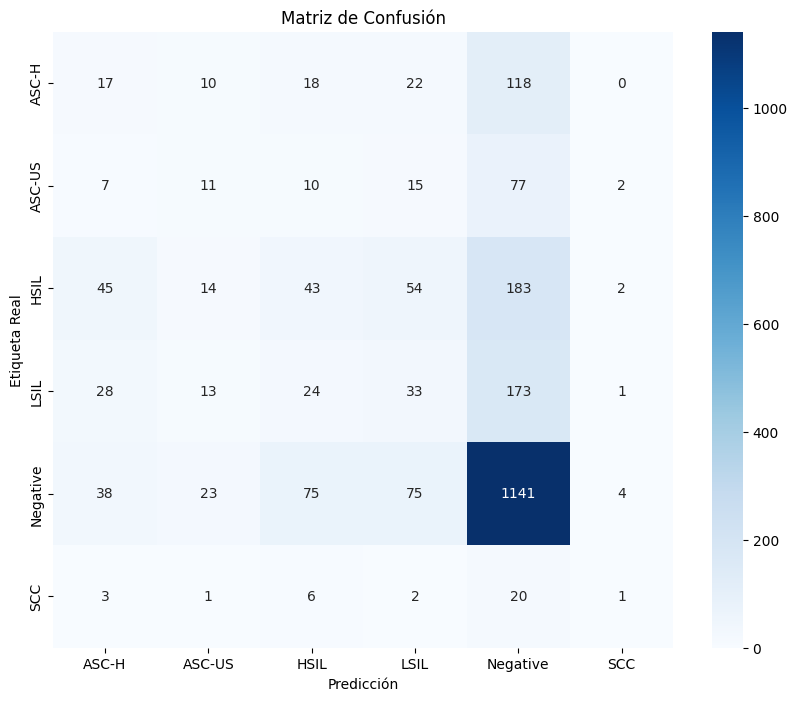

In [145]:
# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

# Modelo MobileNetV3

**Preparación de los datos**

In [ ]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='MobileNetV3')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


**Importar y Definir el Modelo**

In [ ]:
# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_mobilenet.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

**Entrenar el Modelo**

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

Epoch 1/20
231/231 [==============================] - ETA: 0s - loss: 1.0151 - accuracy: 0.6441
Epoch 1: val_loss improved from inf to 0.85304, saving model to best_model_mobilenet.h5


/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


231/231 [==============================] - 112s 470ms/step - loss: 1.0151 - accuracy: 0.6441 - val_loss: 0.8530 - val_accuracy: 0.6914 - lr: 1.0000e-04
Epoch 2/20
231/231 [==============================] - ETA: 0s - loss: 0.8602 - accuracy: 0.6930
Epoch 2: val_loss improved from 0.85304 to 0.82667, saving model to best_model_mobilenet.h5
231/231 [==============================] - 104s 451ms/step - loss: 0.8602 - accuracy: 0.6930 - val_loss: 0.8267 - val_accuracy: 0.7049 - lr: 1.0000e-04
Epoch 3/20
231/231 [==============================] - ETA: 0s - loss: 0.8014 - accuracy: 0.7151
Epoch 3: val_loss improved from 0.82667 to 0.75485, saving model to best_model_mobilenet.h5
231/231 [==============================] - 106s 460ms/step - loss: 0.8014 - accuracy: 0.7151 - val_loss: 0.7548 - val_accuracy: 0.7244 - lr: 1.0000e-04
Epoch 4/20
231/231 [==============================] - ETA: 0s - loss: 0.7705 - accuracy: 0.7236
Epoch 4: val_loss improved from 0.75485 to 0.73557, saving model to best

**Evaluar el Modelo**

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

73/73 [==============================] - 13s 176ms/step - loss: 2.2383 - accuracy: 0.5396
Precisión en el conjunto de prueba: 0.5396


accuracy,▁▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▁▁▁
lr,████████████████▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▅▆▅▆▇▇▅▇▆▆▇██████
val_loss,█▇▄▃▃▃▃▂▁▂▁▂▃▂▂▂▁▁▄▃
accuracy,0.86121
best_epoch,10
best_val_loss,0.67747


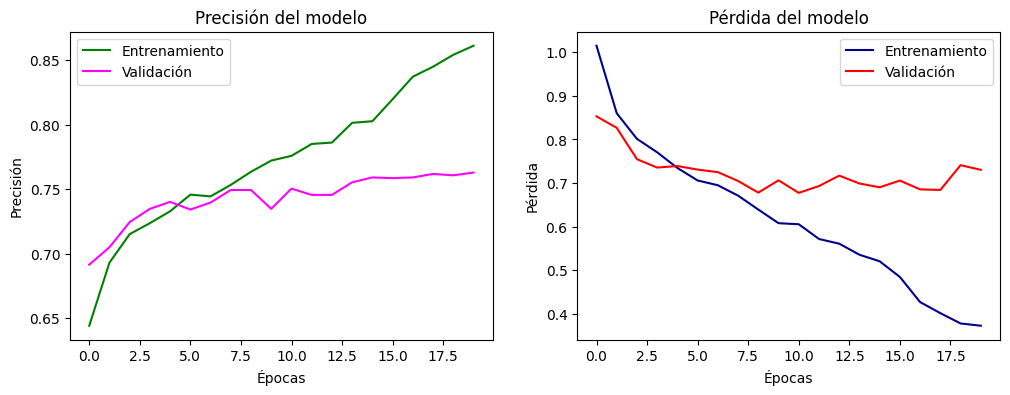

In [ ]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

73/73 [==============================] - 14s 175ms/step
              precision    recall  f1-score   support

       ASC-H       0.12      0.09      0.11       185
      ASC-US       0.15      0.09      0.11       122
        HSIL       0.24      0.13      0.17       341
        LSIL       0.16      0.12      0.14       272
    Negative       0.67      0.84      0.74      1356
         SCC       0.10      0.03      0.05        33

    accuracy                           0.54      2309
   macro avg       0.24      0.22      0.22      2309
weighted avg       0.47      0.54      0.49      2309



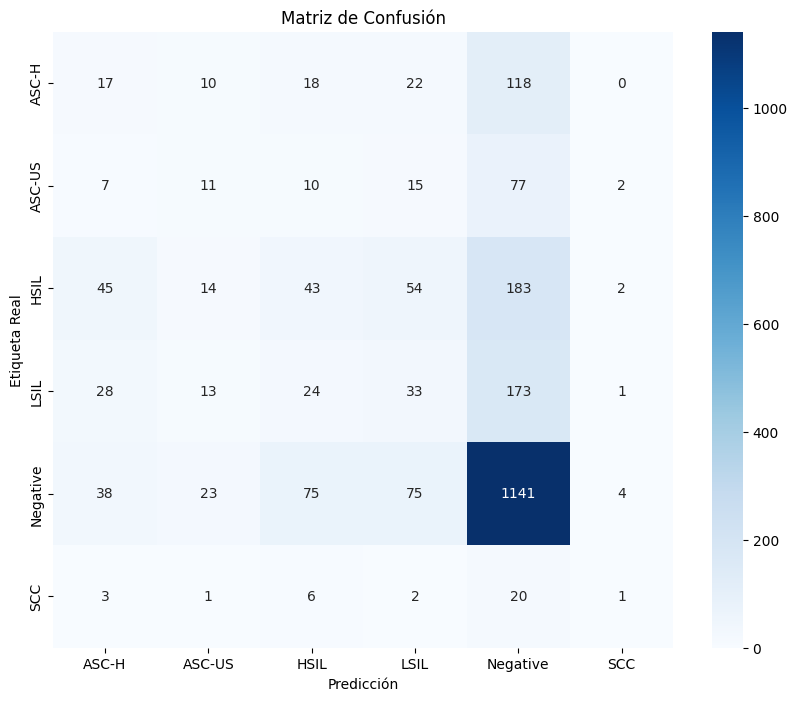

In [ ]:
# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

# Modelo InceptionV3

**Preparación de los datos**

In [8]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='InceptionV3')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 299, 299  # InceptionV3 requiere imágenes de 299x299
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 7378 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


**Importar y Definir el Modelo**

In [3]:
# Importar y Definir el Modelo InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_inception.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


**Entrenar el Modelo**

In [4]:
# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

Epoch 1/20
231/231 [==============================] - ETA: 0s - loss: 0.7778 - accuracy: 0.7173
Epoch 1: val_loss improved from inf to 0.55970, saving model to best_model_inception.h5


/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


231/231 [==============================] - 685s 3s/step - loss: 0.7778 - accuracy: 0.7173 - val_loss: 0.5597 - val_accuracy: 0.7943 - lr: 1.0000e-04
Epoch 2/20
231/231 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.8218
Epoch 2: val_loss improved from 0.55970 to 0.51191, saving model to best_model_inception.h5
231/231 [==============================] - 750s 3s/step - loss: 0.4979 - accuracy: 0.8218 - val_loss: 0.5119 - val_accuracy: 0.8121 - lr: 1.0000e-04
Epoch 3/20
231/231 [==============================] - ETA: 0s - loss: 0.3635 - accuracy: 0.8706
Epoch 3: val_loss improved from 0.51191 to 0.47296, saving model to best_model_inception.h5
231/231 [==============================] - 718s 3s/step - loss: 0.3635 - accuracy: 0.8706 - val_loss: 0.4730 - val_accuracy: 0.8349 - lr: 1.0000e-04
Epoch 4/20
231/231 [==============================] - ETA: 0s - loss: 0.3051 - accuracy: 0.8899
Epoch 4: val_loss did not improve from 0.47296
231/231 [=========================

**Evaluar el Modelo**

In [5]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

73/73 [==============================] - 99s 1s/step - loss: 2.7641 - accuracy: 0.4894
Precisión en el conjunto de prueba: 0.4894


accuracy,▁▄▅▅▆▇▇▇█████
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▅▄▄▃▂▂▂▁▁▁▁▁
lr,████████▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▄▅▅▆▇▇█▇██
val_loss,▆▃▁▁▂▄▄▆▅▃▆▅█
accuracy,0.99553
best_epoch,2
best_val_loss,0.47296


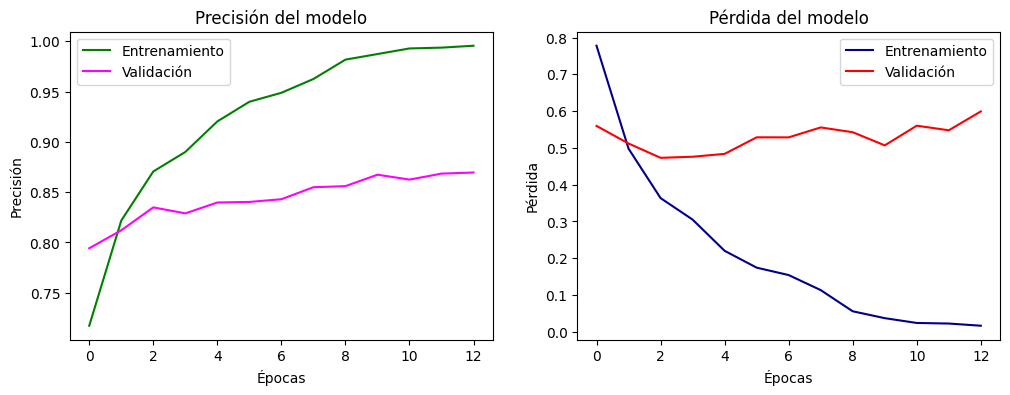

In [6]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

In [7]:
# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

73/73 [==============================] - 90s 1s/step


NameError: name 'classification_report' is not defined

# Modelo Xception

**Preparación de los datos**

In [2]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='Xception-balanceado')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 299, 299  # Xception también requiere 299x299
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


**Importar y Definir el Modelo**

In [3]:
# Importar y Definir el Modelo Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_xception.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


**Entrenar el Modelo**

In [4]:
# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)


Epoch 1/20
254/254 [==============================] - ETA: 0s - loss: 0.8885 - accuracy: 0.6754
Epoch 1: val_loss improved from inf to 0.63242, saving model to best_model_xception.h5


/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


254/254 [==============================] - 913s 4s/step - loss: 0.8885 - accuracy: 0.6754 - val_loss: 0.6324 - val_accuracy: 0.7683 - lr: 1.0000e-04
Epoch 2/20
254/254 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.7886
Epoch 2: val_loss improved from 0.63242 to 0.56733, saving model to best_model_xception.h5
254/254 [==============================] - 988s 4s/step - loss: 0.5736 - accuracy: 0.7886 - val_loss: 0.5673 - val_accuracy: 0.7916 - lr: 1.0000e-04
Epoch 3/20
254/254 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.8348
Epoch 3: val_loss improved from 0.56733 to 0.51964, saving model to best_model_xception.h5
254/254 [==============================] - 882s 3s/step - loss: 0.4546 - accuracy: 0.8348 - val_loss: 0.5196 - val_accuracy: 0.8110 - lr: 1.0000e-04
Epoch 4/20
254/254 [==============================] - ETA: 0s - loss: 0.3422 - accuracy: 0.8756
Epoch 4: val_loss improved from 0.51964 to 0.51539, saving model to best_model_xcep

**Evaluar el Modelo**

In [5]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

73/73 [==============================] - 153s 2s/step - loss: 1.8994 - accuracy: 0.5175
Precisión en el conjunto de prueba: 0.5175


accuracy,▁▄▅▅▆▇▇▇██████
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▅▄▄▃▂▂▂▁▁▁▁▁▁
lr,█████████▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▅▅▆▇▆▇██▇██
val_loss,▆▃▁▁▂▃▃▅▆▆▅██▇
accuracy,0.99049
best_epoch,3
best_val_loss,0.51539


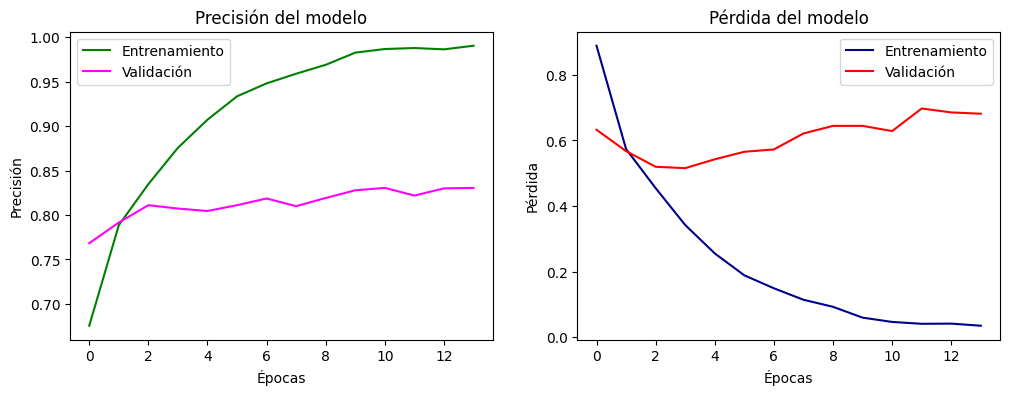

In [6]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

In [8]:
# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

73/73 [==============================] - 135s 2s/step


NameError: name 'classification_report' is not defined

              precision    recall  f1-score   support

       ASC-H       0.14      0.12      0.13       185
      ASC-US       0.11      0.09      0.10       122
        HSIL       0.34      0.16      0.22       341
        LSIL       0.17      0.16      0.16       272
    Negative       0.66      0.78      0.72      1356
         SCC       0.07      0.06      0.07        33

    accuracy                           0.52      2309
   macro avg       0.25      0.23      0.23      2309
weighted avg       0.48      0.52      0.49      2309



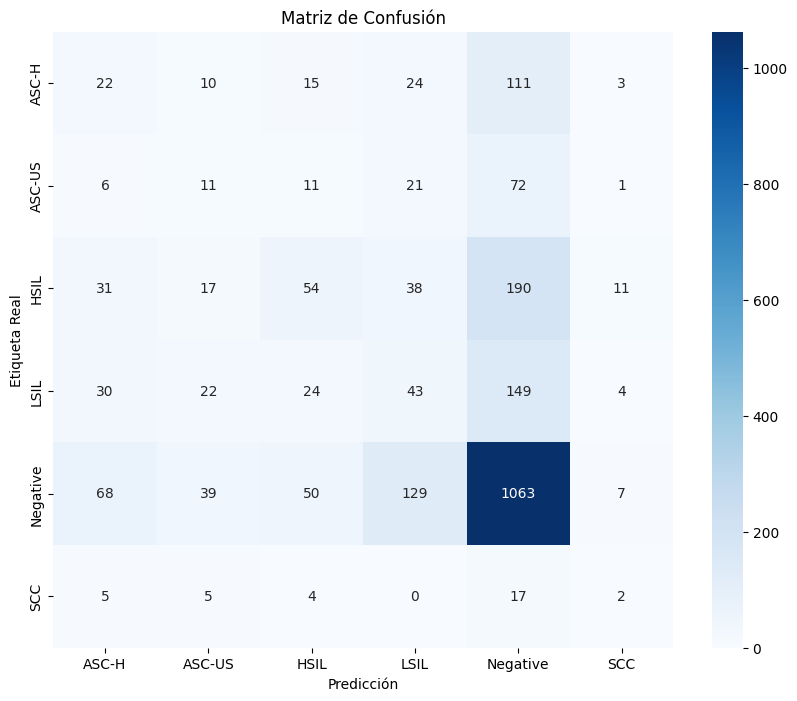

In [12]:
# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()